This project features a unconditional GANs model for images of Heat Transfer numerical simulation.

**Training set** - Set of images with:
*   Total images: 2835
*   Image size: 256 x 256 x 1

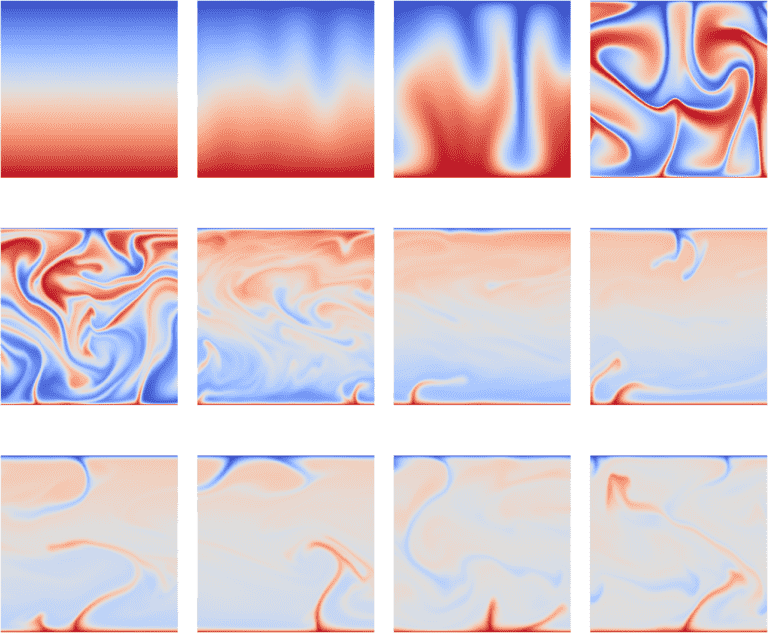



After training for 1,500 epochs, here are some generated images.
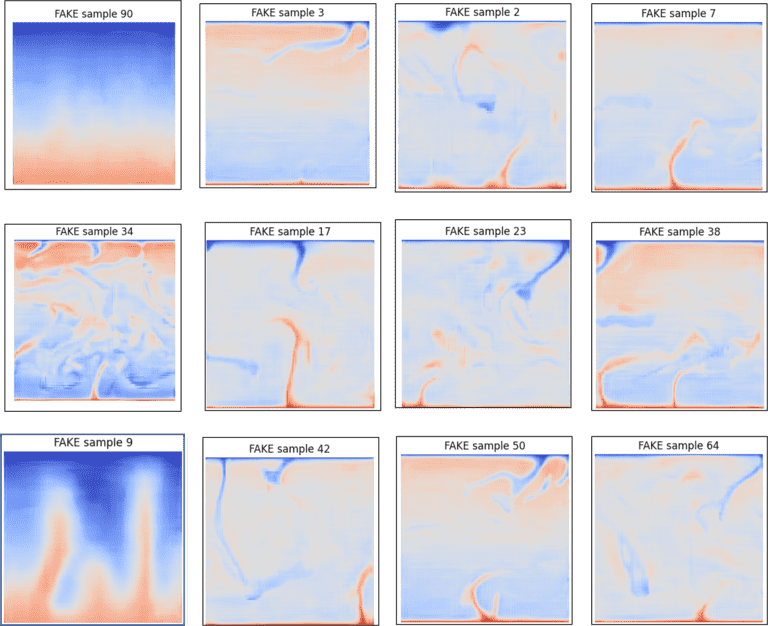


*References*

Jason Brownlee. [How to Develop an Information Maximizing GAN (InfoGAN) in Keras ](https://machinelearningmastery.com/how-to-develop-an-information-maximizing-generative-adversarial-network-infogan-in-keras/). Accessed: 2022-08-01. 2019.

Kuan Wei. [Build InfoGAN From Scratch.](https://towardsdatascience.com/build-infogan-from-scratch-f20ee85cba03). Accessed: 2022-08-01. 2020.

François Chollet. [DCGAN to generate face image](https://keras.io/examples/generative/dcgan_overriding_train_step/). Accessed: 2022-08-01. 2021.




In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import os
import gdown
from tqdm import tqdm
from PIL import Image

path_a1 = f'dataset_a1'       # Replace with your path to dataset 
path_a2 = f'dataset_a2'       # Replace with your path to dataset 
path_b1 = f'dataset_b1'       # Replace with your path to dataset 

dataset = keras.preprocessing.image_dataset_from_directory(
    path_a1, label_mode=None, image_size=(256,256),
    batch_size=32,shuffle =True,color_mode="grayscale")
dataset = dataset.map(lambda x: (x/255) *2 - 1)

Found 1008 files belonging to 1 classes.


In [ ]:
latent_dim = 4096

def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Reshape(target_shape = [1, 1, 4096], input_shape = [4096]))
    assert model.output_shape == (None, 1, 1, 4096)
        
    
    model.add(layers.Conv2DTranspose(filters = 256, kernel_size = 4))
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 4, 4, 256)
    
    model.add(layers.Conv2D(filters = 256, kernel_size = 4, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 8, 8, 256)
    
    model.add(layers.Conv2D(filters = 128, kernel_size = 4, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 16, 16, 128)
    
    model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 32, 32, 64)
    
    model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 64, 64, 32)
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 128, 128, 16)
    
    model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    assert model.output_shape == (None, 256, 256, 8)
    
    model.add(layers.Conv2D(filters = 1, kernel_size = 3, padding = 'same'))
    model.add(layers.Activation('tanh'))
    assert model.output_shape == (None, 256, 256, 1)
    
    return model

# declares the generator
generator = generator_model()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 4096)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        16777472  
 nspose)                                                         
                                                                 
 activation (Activation)     (None, 4, 4, 256)         0         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 256)         1048832   
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 256)        1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 4, 4, 256)         0

In [ ]:
def discriminator_model():
    model = tf.keras.Sequential()
        
    #add Gaussian noise to prevent Discriminator overfitting
    model.add(layers.GaussianNoise(0.2, input_shape = [256, 256, 1]))
    
    #256x256x3 Image
    model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #128x128x8
    model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #64x64x16
    model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #32x32x32
    model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #16x16x64
    model.add(layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #8x8x128
    model.add(layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
    model.add(layers.BatchNormalization(momentum = 0.7))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.AveragePooling2D())
    
    #4x4x256
    model.add(layers.Flatten())
    
    #256
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    return model
  
# Declares the discriminator
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 256, 256, 1)      0         
 se)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 8)       80        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 8)       0         
                                                                 
 dropout (Dropout)           (None, 256, 256, 8)       0         
                                                                 
 average_pooling2d (AverageP  (None, 128, 128, 8)      0         
 ooling2D)                                                       
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 16)     

In [ ]:
class simpleGAN(keras.Model):
    def __init__(self, d_model, g_model, latent_dim):
        super(simpleGAN, self).__init__()
        self.d_model = d_model
        self.g_model = g_model
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(simpleGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def train_step(self, real_image_batch):
        # Define loss functions
        binary_loss = keras.losses.BinaryCrossentropy()
        # Half-batch for training discriminator and batch for training generator and auxiliary model
        batch = tf.shape(real_image_batch)[0]
        # Create generator input 
        random_latent_vectors = tf.random.normal(shape=(batch, self.latent_dim))

        with tf.GradientTape() as d_tape: 
            self.d_model.trainable = True
            d_tape.watch(self.d_model.trainable_variables)

            # Train discriminator using half batch real images
            y_disc_real = tf.ones((batch, 1))
            d_real_output = self.d_model(real_image_batch, training=True)
            d_loss_real = binary_loss(y_disc_real, d_real_output)
            
            # Train discriminator using half batch fake images     
            y_disc_fake = tf.zeros((batch, 1))
            # Create fake image batch
            fake_image_batch = self.g_model(random_latent_vectors, training=True)
            d_fake_output = self.d_model(fake_image_batch, training=True)
            d_loss_fake = binary_loss(y_disc_fake, d_fake_output)

            d_loss = d_loss_real + d_loss_fake
        # Calculate gradients
        d_gradients = d_tape.gradient(d_loss, self.d_model.trainable_variables)
        # Optimize
        self.d_optimizer.apply_gradients(zip(d_gradients, self.d_model.trainable_variables))


        with tf.GradientTape() as g_tape:
            # Create generator input 
            random_latent_vectors = tf.random.normal(shape=(batch*2, self.latent_dim))
            g_tape.watch(self.g_model.trainable_variables)

            # Create fake image batch
            fake_image_batch = self.g_model(random_latent_vectors, training=True)
            d_fake_output = self.d_model(fake_image_batch, training=True)
            y_gen_fake = tf.ones((batch*2, 1))
            g_img_loss = binary_loss(y_gen_fake, d_fake_output)  

            g_loss = g_img_loss 
        # Calculate gradients
        # We do not want to modify the neurons in the discriminator when training the generator and the auxiliary model
        self.d_model.trainable=False
        g_gradients = g_tape.gradient(g_loss, self.g_model.trainable_variables)
        # Optimize
        self.g_optimizer.apply_gradients(zip(g_gradients, self.g_model.trainable_variables))
       
        return {"d_loss_real": d_loss_real, "d_loss_fake": d_loss_fake, "g_img_loss": g_img_loss}


In [ ]:
# Create a new model instance
simple_gan = simpleGAN(discriminator, generator,  latent_dim=4096)
simple_gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=2e-4),
                g_optimizer=keras.optimizers.Adam(learning_rate=5e-4))

In [ ]:
# Restore the weights
#simple_gan.load_weights('save_path')       # Replace with your path to stored weights 

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='save_path', save_freq = 32*50,save_weights_only=True)

# Resume training
first = 0
last = 1
simple_gan.fit(dataset, epochs=last, initial_epoch = first, callbacks=[cp_callback])

In [ ]:
# Result 1: Load Simple GAN model's weights
simple_gan.load_weights('save_path')       # Replace with your path to stored weights 

In [ ]:
# Generate fake images
tf.random.set_seed(100)
random_latent_vectors = tf.random.normal(shape=(200, 4096), seed = 100)
F1 = np.squeeze(simple_gan.g_model(random_latent_vectors))

# Compute statistics vectors
M_1 = np.mean(F1,axis= 2)
M_2 = np.var(F1,axis= 2)
#M_3 = scipy.stats.skew(F1,axis= 2)
#M_4 = scipy.stats.kurtosis(F1,axis= 2)


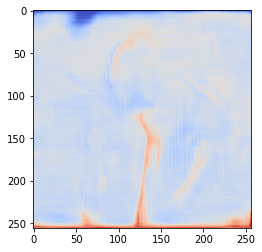

In [ ]:
# Display one image from F1
plt.imshow(F1[10], cmap = "coolwarm_r")
plt.show()